In [ ]:
!pip3 install fastai torch torchvision fastbook

In [1]:
import os
from pprint import pprint
import requests

In [2]:
from fastai.vision.widgets import *
import fastbook
fastbook.setup_book()
from fastbook import *

/home/nrs/.local/lib/python3.7/site-packages/fastbook/__init__.py:22: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [3]:
bing_api_key = "1ef8e281347a435c9ccccd1848419317"
model_name = "bears_cnn_classifier.pkl"
bears_path = "bears"

In [4]:
def image_search(api_key, query, num_imgs=100):
    headers = {"Ocp-Apim-Subscription-Key": api_key}
    params = {"q": query, "count": num_imgs}
    response = requests.get(
        "https://api.cognitive.microsoft.com/bing/v7.0/images/search",
        headers=headers,
        params=params
    )
    return response.json()

In [5]:
def download_img(url, img_path):
    try:
        img_response = requests.get(url)
    except Exception as e:
        print(f"Failed to get image from {url}: {str(e)}")
        return
    
    file = open(img_path, "wb+")
    file.write(img_response.content)
    file.close()

In [6]:
def get_bear_imgs(bear_types):
    for bear_type in bear_types:
        new_bear_type_dir = os.path.join(os.getcwd(), "bears", bear_type)
        os.makedirs(new_bear_type_dir, exist_ok=True)
        bear_img_response = image_search(bing_api_key, f"{bear_type} bear")
        bear_img_urls = [bear_img["contentUrl"] for bear_img in bear_img_response["value"]]

        i = 0
        for bear_img_url in bear_img_urls:
            bear_filename = os.path.join(new_bear_type_dir, f"{bear_type}_bear_{i}.png")
            download_img(bear_img_url, bear_filename)
            i += 1

In [6]:
bear_types = ["grizzly", "black", "teddy"]
get_bear_imgs(bear_types)

Failed to get image from https://assets.vancouverisawesome.com/wp-content/uploads/2018/07/08143100/grizzly-bear.jpg: HTTPSConnectionPool(host='assets.vancouverisawesome.com', port=443): Max retries exceeded with url: /wp-content/uploads/2018/07/08143100/grizzly-bear.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f52f46beb00>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Failed to get image from https://assets.vancouverisawesome.com/wp-content/uploads/2017/12/18131050/grizzly-bears.jpg: HTTPSConnectionPool(host='assets.vancouverisawesome.com', port=443): Max retries exceeded with url: /wp-content/uploads/2017/12/18131050/grizzly-bears.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f52f491bdd8>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Failed to get image from https://media.mnn.com/assets/images/2015/07/Jaymi-Heimbuch-grizzly-bear

In [9]:
fns = get_image_files("bears")
failed = verify_images(fns)
for failed_img in failed:
    os.remove(failed_img)

In [10]:
bears = DataBlock(
    # Form of input and label data
    blocks=(ImageBlock, CategoryBlock), 
    # How to read data
    get_items=get_image_files, 
    # Split into training and validation data
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Get parent dir of image to get label (e.g. bears/black/black_bear_1.png)
    get_y=parent_label,
    # Resize each image to 128x128
    item_tfms=Resize(128)
)

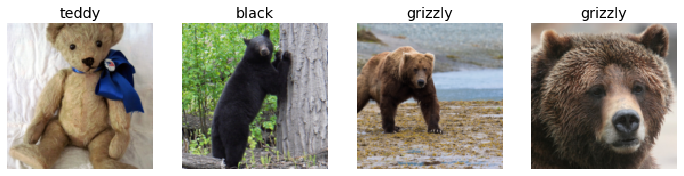

In [11]:
dls = bears.dataloaders(bears_path)
dls.valid.show_batch(max_n=4, nrows=1)

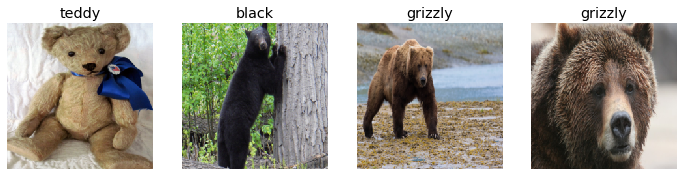

In [14]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(bears_path)
dls.valid.show_batch(max_n=4, nrows=1)

In [13]:
# Pretrained model (ResNet18) using error rate as model metric
learn = cnn_learner(dls, resnet18, metrics=error_rate)
# Fine-tune on bears dataset for 4 epochs
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.731594,1.143789,0.490566,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.342615,0.199049,0.075472,00:14
1,0.218206,0.013222,0.000000,00:15
2,0.151768,0.002526,0.000000,00:14
3,0.119522,0.001669,0.000000,00:14


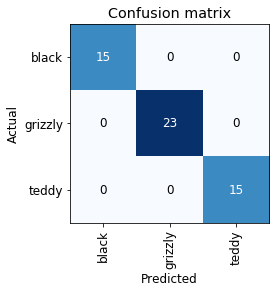

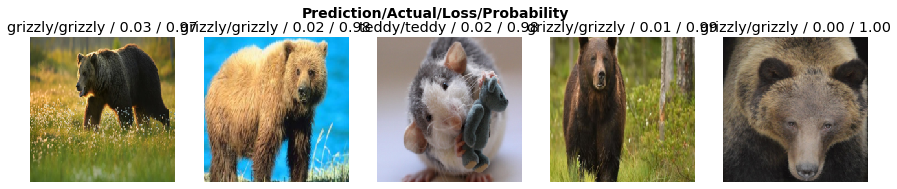

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

In [1]:
learn.export(fname=model_name)

NameError: name 'learn' is not defined

In [7]:
learn_inf = load_learner(fname=model_name)
learn_inf.predict("bears/teddy/teddy_bear_0.png")

('teddy', tensor(2), tensor([3.6120e-08, 6.2115e-06, 9.9999e-01]))

In [6]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

In [7]:
#hide_output
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')